### Importing libraries 

In [141]:
import pandas as pd
import seaborn as sns
import numpy as np
from dateutil import parser
import matplotlib as plt

### Importing Data

In [142]:
df = pd.read_csv('data/ytdataframe.csv')

dff = pd.read_csv(r'C:\Users\wled3\ytunlabeled.csv')

In [143]:
df.head(5)

,Unnamed: 0,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,subscribers,totalViews,totalVideos,total polarity score,Label
0,0,-SejlHOXexc,Tech Tutorial,How to download facebook stories in your phone,Hey friends today we have another great topic ...,"['facebook stories in your phone', 'download f...",2019-11-02T14:25:35Z,968252,11104,NaN,338,PT3M55S,hd,False,140000,8642059,161,0.0082,non reputable
1,1,set4Kr8hX0w,Tech Tutorial,How to check whatsapp lastseen if hidden or bl...,Hello friends welcome to my channel Our today...,['How to check whatsapp lastseen if hidden or ...,2018-01-20T15:35:36Z,1477841,11931,NaN,860,PT4M44S,hd,False,140000,8642059,161,0.1820,non reputable
2,2,s4EYU1ptpIs,Tech Tutorial,How to change voice during call | Male female ...,Hey friends today we have another great topic ...,"['How to change voice during call', 'voice cha...",2021-11-30T17:37:11Z,542795,9114,NaN,332,PT5M21S,hd,False,140000,8642059,161,0.0890,non reputable
3,3,-lcPJAa6trw,Tech Tutorial,How to check who read my message in whatsapp g...,Hey friends today we have another great topic ...,['how to check who read message in whatsapp gr...,2018-05-07T15:12:51Z,322980,5359,NaN,266,PT3M,hd,False,140000,8642059,161,0.3620,non reputable
4,4,G1F6W7QhrWU,Tech Tutorial,How to Record Messenger calls -facebook messen...,Hey friends today we have another great topic ...,"['How to Record Messenger calls', 'facebook me...",2021-10-07T16:18:54Z,42017,321,NaN,19,PT4M23S,hd,False,140000,8642059,161,0.3250,non reputable


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            106 non-null    int64  
 1   video_id              106 non-null    object 
 2   channelTitle          106 non-null    object 
 3   title                 106 non-null    object 
 4   description           106 non-null    object 
 5   tags                  99 non-null     object 
 6   publishedAt           106 non-null    object 
 7   viewCount             106 non-null    int64  
 8   likeCount             106 non-null    int64  
 9   favouriteCount        0 non-null      float64
 10  commentCount          106 non-null    int64  
 11  duration              106 non-null    object 
 12  definition            106 non-null    object 
 13  caption               106 non-null    bool   
 14  subscribers           106 non-null    int64  
 15  totalViews            1

# Data preprocessing 

Checking duplicates

In [145]:
df.duplicated().sum()


0

In [146]:
df = df.drop_duplicates()
df.shape

(106, 19)

Checking null values

In [147]:
df.isnull().sum()


Unnamed: 0                0
video_id                  0
channelTitle              0
title                     0
description               0
tags                      7
publishedAt               0
viewCount                 0
likeCount                 0
favouriteCount          106
commentCount              0
duration                  0
definition                0
caption                   0
subscribers               0
totalViews                0
totalVideos               0
total polarity score      0
Label                     0
dtype: int64

Convert count columns to numeric

In [148]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

dff[numeric_cols] = dff[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

Convert publish date to year

In [149]:
df['publishedAt'] = df['publishedAt'].apply(lambda x: parser.parse(x)) 
df['pushblishYear'] = df['publishedAt'].apply(lambda x: x.strftime("%Y"))

dff['publishedAt'] = dff['publishedAt'].apply(lambda x: parser.parse(x)) 
dff['pushblishYear'] = dff['publishedAt'].apply(lambda x: x.strftime("%Y"))

Convert duration to seconds

In [150]:
import isodate
df['durationSecs'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
df['durationSecs'] = df['durationSecs'].astype('timedelta64[s]')

dff['durationSecs'] = dff['duration'].apply(lambda x: isodate.parse_duration(x))
dff['durationSecs'] = dff['durationSecs'].astype('timedelta64[s]')

Add tag count

In [151]:


df['tagCount'] = df['tags'].apply(lambda x: 0 if x is np.nan else len(x))

dff['tagCount'] = dff['tags'].apply(lambda x: 0 if x is np.nan else len(x))

Dropping columns we wont use

In [152]:
df = df.drop(['Unnamed: 0', 'publishedAt', 'duration', 'favouriteCount', 'video_id', 'tags'], axis=1)

dff = dff.drop(['Unnamed: 0', 'publishedAt', 'duration', 'favouriteCount', 'video_id', 'tags'], axis=1)


# EDA

### Label distribution 

reputable        75
non reputable    31
Name: Label, dtype: int64

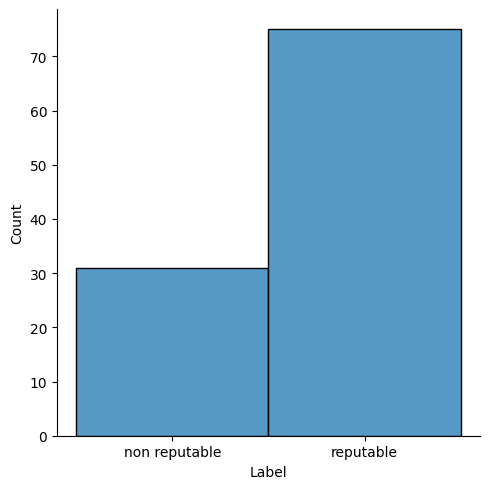

In [153]:
sns.displot(df, x="Label")
df["Label"].value_counts()

Our data is unbalanced so we might need oversampling

<AxesSubplot:xlabel='total polarity score', ylabel='commentCount'>

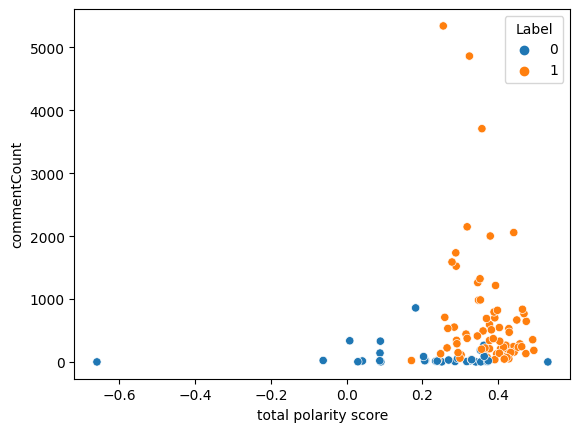

In [183]:
sns.scatterplot(x="total polarity score", y="commentCount", hue="Label", data = df)

# Modeling

In [155]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [156]:
le = LabelEncoder()

df2 = ['channelTitle', 'title', 'description', 'definition', 'caption', 'Label']

df[df2] = df[df2].apply(le.fit_transform)

dffs = ['channelTitle', 'title', 'description', 'definition', 'caption']
dff[dffs] = dff[dffs].apply(le.fit_transform)



df.head(1)

,channelTitle,title,description,viewCount,likeCount,commentCount,definition,caption,subscribers,totalViews,totalVideos,total polarity score,Label,pushblishYear,durationSecs,tagCount
0,13,44,30,968252.0,11104.0,338.0,0,0,140000,8642059,161,0.0082,0,2019,235.0,412


In [158]:
feat_col = ['channelTitle', 'title', 'description', 'viewCount', 'likeCount', 'definition', 'commentCount', 'caption', 'subscribers', 'totalViews', 'totalVideos', 'total polarity score', 'pushblishYear', 'durationSecs', 'tagCount']

X = df[feat_col] # Features
y = df.Label # Target variable

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [160]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, max_iter=1000)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [163]:
from sklearn.metrics import classification_report
target_names = ['reputable', 'non reputable']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

    reputable       0.88      0.88      0.88         8
non reputable       0.95      0.95      0.95        19

     accuracy                           0.93        27
    macro avg       0.91      0.91      0.91        27
 weighted avg       0.93      0.93      0.93        27



In [164]:


print("Train Accuracy:",logreg.score(X_train, y_train))
print("Test Accuracy:",logreg.score(X_test, y_test))

Train Accuracy: 0.9367088607594937
Test Accuracy: 0.9259259259259259


In [165]:
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(max_iter=1000)
cross_val = KFold(n_splits=3, random_state=16, shuffle=True)
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Logistic Regression: ", scores.mean())

Mean AUC Score - Logistic Regression:  0.9276515151515151


# Testing different models

### Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
kfold = KFold(n_splits=3, random_state=16, shuffle=True) 
scores = cross_val_score(model1, X_train, y_train, cv=kfold, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.9833333333333334


In [167]:
# fit the model with data
model1.fit(X_train, y_train)

rf_pred = model1.predict(X_test)

print("Train Accuracy:",model1.score(X_train, y_train))
print("Test Accuracy:",model1.score(X_test, y_test))

Train Accuracy: 1.0
Test Accuracy: 0.9259259259259259


### Decision Tree

In [168]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()
cross_val = KFold(n_splits=3, random_state=16, shuffle=True)
scores = cross_val_score(model2, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

Mean AUC Score - Decision Tree:  0.9335227272727273


In [169]:
# fit the model with data
model2.fit(X_train, y_train)

dc_pred = model2.predict(X_test)

print("Train Accuracy:",model2.score(X_train, y_train))
print("Test Accuracy:",model2.score(X_test, y_test))

Train Accuracy: 1.0
Test Accuracy: 0.9629629629629629


### Gaussian Naive Bayes

In [170]:
from sklearn.naive_bayes import GaussianNB
model4 = GaussianNB()
cross_val = KFold(n_splits=3, random_state=16, shuffle=True)
scores = cross_val_score(model4, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Gaussian Naive Bayes: ", scores.mean())

Mean AUC Score - Gaussian Naive Bayes:  0.9066287878787879


In [171]:
# fit the model with data
model4.fit(X_train, y_train)

gn_pred = model4.predict(X_test)

print("Train Accuracy:",model4.score(X_train, y_train))
print("Test Accuracy:",model4.score(X_test, y_test))

Train Accuracy: 0.8354430379746836
Test Accuracy: 0.7407407407407407


### K-Nearest Neighbors

In [172]:
from sklearn.neighbors import KNeighborsClassifier
model5 = KNeighborsClassifier()
cross_val = KFold(n_splits=3, random_state=16, shuffle=True)
scores = cross_val_score(model5, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - K-Nearest Neighbors: ", scores.mean())

Mean AUC Score - K-Nearest Neighbors:  0.9347537878787878


In [173]:
# fit the model with data
model5.fit(X_train, y_train)

k_pred = model5.predict(X_test)

print("Train Accuracy:",model5.score(X_train, y_train))
print("Test Accuracy:",model5.score(X_test, y_test))

Train Accuracy: 0.9493670886075949
Test Accuracy: 0.9259259259259259


From the 5 scores above the top 3 performers were Logistic Regression and Random Forest and K-Neasrest Neighbors. We will move ahead and fine tune them.

# Hyper parameters tuning

In [180]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': np.linspace(.0001, 1000, 200) , 'penalty': [ "l1", "l2"]}]
clf = GridSearchCV(logreg, tuned_parameters, cv=cross_val, scoring= 'roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print("\nOptimized model achieved an ROC of:", round(clf.score(X_train, y_train), 4))

Best parameters set found on development set:

{'C': 1335.6679205602802, 'penalty': 'l2'}

Optimized model achieved an ROC of: 0.9775


c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6000 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or

# Save model

In [175]:
import pickle

pickle.dump(clf, open('LogRegModel', 'wb'))

# Labelling data using our model

Reindexing

In [ ]:
new_cols = ["channelTitle","title","description","viewCount",'likeCount','definition','commentCount','caption','subscribers','totalViews','totalVideos','total polarity score','pushblishYear','durationSecs','tagCount']
dff=dff[new_cols]
#or
dff=dff.reindex(columns=new_cols)

Labeling

In [ ]:
new_pred = logreg.predict(dff)
print(new_pred)

Assigning the labels

In [ ]:
dff['Label'] = None

dff = dff.assign(Label = new_pred)